# Zonally Averaged Overturning Circulation

This notebook shows a simple example of calculation the zonally averaged global meridional overturning circulation - in density space - using output from either `MOM5` or `MOM6`.

**Requirements:** The `conda/analysis3` (or later) module on ARE. I recommend an ARE session with more than 14 cores to make these computations.

**Firstly,** load in the requisite libraries:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
from dask.distributed import Client
from scipy.interpolate import interp1d
import xarray as xr
import cf_xarray as cfxr

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37079/status,
Dashboard: /proxy/37079/status,Workers: 7
Total threads: 28,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40479,Workers: 7
Dashboard: /proxy/37079/status,Total threads: 28
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:37585,Total threads: 4
Dashboard: /proxy/34779/status,Memory: 35.71 GiB
Nanny: tcp://127.0.0.1:41911,


**At this stage**, you need to denote whether the experiment uses output from `MOM5` or `MOM6`.

This notebook is designed to use `cf-xarray` and a dictionary of `querying.getvar` arguments to load the correct variables independent of the model. 

In [3]:
session = cc.database.create_session()

**Next,** choose an experiment. The dictionary below denotes which experiment we want to use for each model.

We can choose experiments at any resolution. For MOM5-based runs, they can be with or without Gent-McWilliams eddy parameterisation.

For this example, we are choosing to limit ourselves to just the last 20 years of the 0.25° control simulations. If you want to increase the resolution or integrate over a longer time you might need more resources!

In [4]:
psi_args = {
    "mom5": {
        "expt": "01deg_jra55v13_ryf9091",
        "variable": "ty_trans_rho",
        "start_time": "2152-01-01",
        "end_time": "2154-12-31"
    },
    "mom6": {
        "expt": "panant-01-zstar-ACCESSyr2",
        "variable": "vmo",
        "start_time": "2001-01-01",
        "end_time": "2002-01-01",
        "frequency": "1 monthly",
        "attrs": {"cell_methods": "rho2_l:sum yq:point xh:sum time: mean"},
    }
}


setting the dictionary for the remapping function:

In [5]:
remap_dens = {
    "mom5": {
        "expt": "01deg_jra55v13_ryf9091",
        "frequency": "1 monthly",
        "rho_2" : "pot_rho_2",
        "depth" : "st_ocean",
        "latitude_c": "yt_ocean",
        "latitude_b": "yu_ocean",
        "latitude_bsect": "grid_yu_ocean"
    },
    "mom6": {
        "expt": "panant-01-zstar-ACCESSyr2",
        "frequency": "1 monthly",
        "rho_2" : "rhopot2",
        "depth" : "z_l",
        "latitude_c": "yh",
        "latitude_b": "yq",
        "latitude_bsect": "yq",
        "attrs": {"cell_methods": "rho2_l:sum yq:point xh:sum time: mean"},
    }
}

Defining the remapping function

In [7]:
def remap_depth(remap_dens,psi_args,psi_avg,session,model):
    rho2 = cc.querying.getvar(psi_args[model]["expt"], remap_dens[model]["rho_2"], session, start_time=psi_args[model]["start_time"], end_time=psi_args[model]["end_time"])
    #Masking the mediteranean in mom5
    if model=='mom5': rho2=rho2.where(((rho2.xt_ocean<0) | (rho2.xt_ocean>45) ) | ((rho2.yt_ocean<10) | (rho2.yt_ocean>48)))
    rho2_mean = rho2.sel(time=slice(psi_args[model]["start_time"], psi_args[model]["end_time"])).mean('time')
    rho2_zonal_mean = rho2_mean.cf.mean("longitude").load()

    if model=='mom5':
        nmax=np.size(rho2_zonal_mean.yt_ocean)
        nmin=59
    elif model=='mom6':
        nmax=np.size(rho2_zonal_mean.yh)
        nmin=75
        
    z1 = rho2_zonal_mean[remap_dens[model]["depth"]].values 
    psi_depth = psi_avg.copy()*0.0
    for ii in range(nmin,nmax):
        if model=='mom5':
            rho1 = rho2_zonal_mean.isel(yt_ocean=ii).values
            f = interp1d(rho1,z1,bounds_error=False,fill_value = (0,'NaN'))
            psi_depth[:,ii] = np.nan_to_num(f(psi_avg.potrho.values),nan=6000)
        elif model=='mom6':
            rho1 = rho2_zonal_mean.isel(yh=ii).values
            f = interp1d(rho1,z1,bounds_error=False,fill_value = (0,'NaN'))
            psi_depth[:,ii] = np.nan_to_num(f(psi_avg.rho2_l.values),nan=6000)


    psi_avg2=psi_avg.rename({remap_dens[model]["latitude_bsect"]:'latitude_b'}) #Purely for automatic renaming later


    new_psi_avg = xr.DataArray(data=psi_avg2.values,dims=[remap_dens[model]["rho_2"], 'latitude_b'],
                               coords=dict(latitude_b=(["latitude_b"], psi_avg2["latitude_b"].values),
                                           depth=([remap_dens[model]["rho_2"], "latitude_b"], psi_depth.values)),
                                              attrs= psi_avg.attrs)
    new_psi_avg=new_psi_avg.rename({'latitude_b': remap_dens[model]["latitude_b"]})
    del psi_avg2
    return psi_depth, new_psi_avg

MOM5: Load up `ty_trans_rho` - and sum zonally.
Also, if there is a `ty_trans_rho_gm` variable saved, assume that GM is switched on and load that as well. Most ACCESS-OM2 and MOM6 simulations save transport with units of kg/s - convert to Sv.

In [8]:
def load_streamfunction(model):
    expt = psi_args[model]["expt"]
    start_time = psi_args[model]["start_time"]
    end_time = psi_args[model]["end_time"]

    psi = cc.querying.getvar(session=session, **psi_args[model])
    psi = psi.sel(time=slice(start_time, end_time))
    psi = psi.cf.sum("longitude")

    psiGM = xr.zeros_like(psi)

    varlist = cc.querying.get_variables(session, expt)
    if varlist['name'].str.contains('ty_trans_rho_gm').any():
        GM = True
        psiGM = cc.querying.getvar(expt, 'ty_trans_rho_gm', session, start_time=start_time)
        psiGM = psiGM.cf.sum("longitude")
    else:
        GM = False
    
    ρ0 = 1025 # mean density of sea-water [kg/m³]
    
    psi = psi / (1e6 * ρ0)
    psiGM = psiGM / (1e6 * ρ0)
    
    return psi, psiGM, GM

Now, we define a function that cumulatively sums the transport in the vertical. Note that in MOM5 the `ty_trans_rho_GM` variable is computed differently and **does not** require summing in the vertical. Once the calculation has been laid out, we then load the variable to force the computation to occur.

In [9]:
def sum_in_vertical(psi, psiGM, GM):
    psi_avg = psi.cf.cumsum("vertical").mean("time") - psi.cf.sum("vertical").mean("time")

    if GM:
        psi_avg = psi_avg + psiGM.cf.mean("time")

    psi_avg.load()
    
    return psi_avg

Let's load everything from a MOM5 model.

In [10]:
model = 'mom5'
psi, psiGM, GM = load_streamfunction(model)
psi_avg = sum_in_vertical(psi, psiGM, GM)

2023-09-04 15:29:38,541 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-09-04 15:29:43,348 - distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
2023-09-04 15:30:07,375 - distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
2023-09-04 15:30:09,644 - distributed.utils_perf - WARNING - full garbage collections took 50% CPU time recently (threshold: 10%)
2023-09-04 15:30:30,791 - distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
2023-09-04 15:30:42,252 - distributed.utils_perf - WARNING - full garbage collections took 50% CPU time recently (threshold: 10%)
2023-09-04 15:30:56,747 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-04 15:31:15,252 - distributed.utils_perf - WARNING - full garbage collections took

Now we are ready to plot. We usually plot the streamfunction over a reduced range of density levels to highlight the deep ocean contribution...

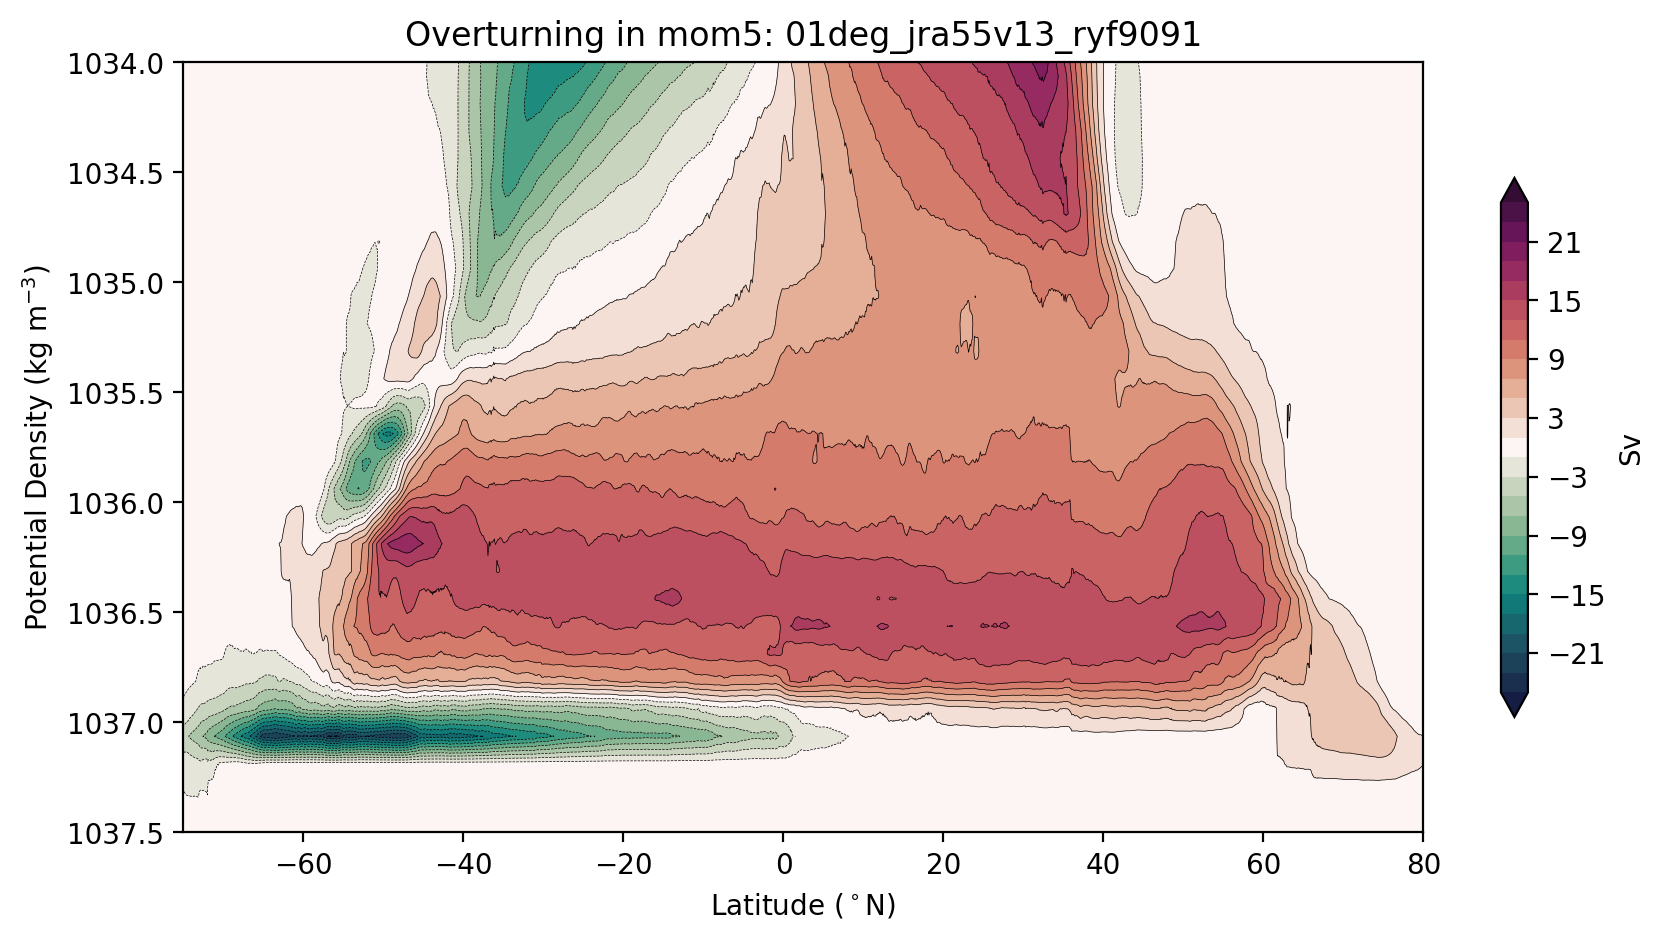

In [11]:
plt.figure(figsize=(10, 5))

max_psi = 25 # Sv

# how we compute the levels may seem complicated, we just want to avoid a 0 contour
# so that the plot looks soothing to the eye
levels =  np.hstack((np.arange(-max_psi, 0, 2), np.flip(-np.arange(-max_psi, 0, 2))))
cbarticks = np.hstack((np.flip(-np.arange(3, max_psi, 6)), np.arange(3, max_psi, 6)))

psi_avg.plot.contourf(levels=levels,
                      cmap=cm.cm.curl, extend='both',
                      cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})

psi_avg.plot.contour(levels=levels, colors='k', linewidths=0.25)

plt.gca().invert_yaxis()

plt.ylim((1037.5, 1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 80])
plt.title(f'Overturning in {model}: {psi_args[model]["expt"]}');

Now let's remap the overturning into depth coordinates

In [12]:
psi_depth, new_psi_avg = remap_depth(remap_dens,psi_args,psi_avg,session,model)

2023-09-04 15:35:48,963 - distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
2023-09-04 15:35:49,031 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-09-04 15:35:49,170 - distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
2023-09-04 15:35:49,267 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2023-09-04 15:35:49,298 - distributed.utils_perf - WARNING - full garbage collections took 42% CPU time recently (threshold: 10%)
2023-09-04 15:35:50,865 - distributed.utils_perf - WARNING - full garbage collections took 42% CPU time recently (threshold: 10%)
2023-09-04 15:35:56,553 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-09-04 15:35:56,671 - distributed.utils_perf - WARNING - full garbage collections took

Plot of Streamfunction along depth

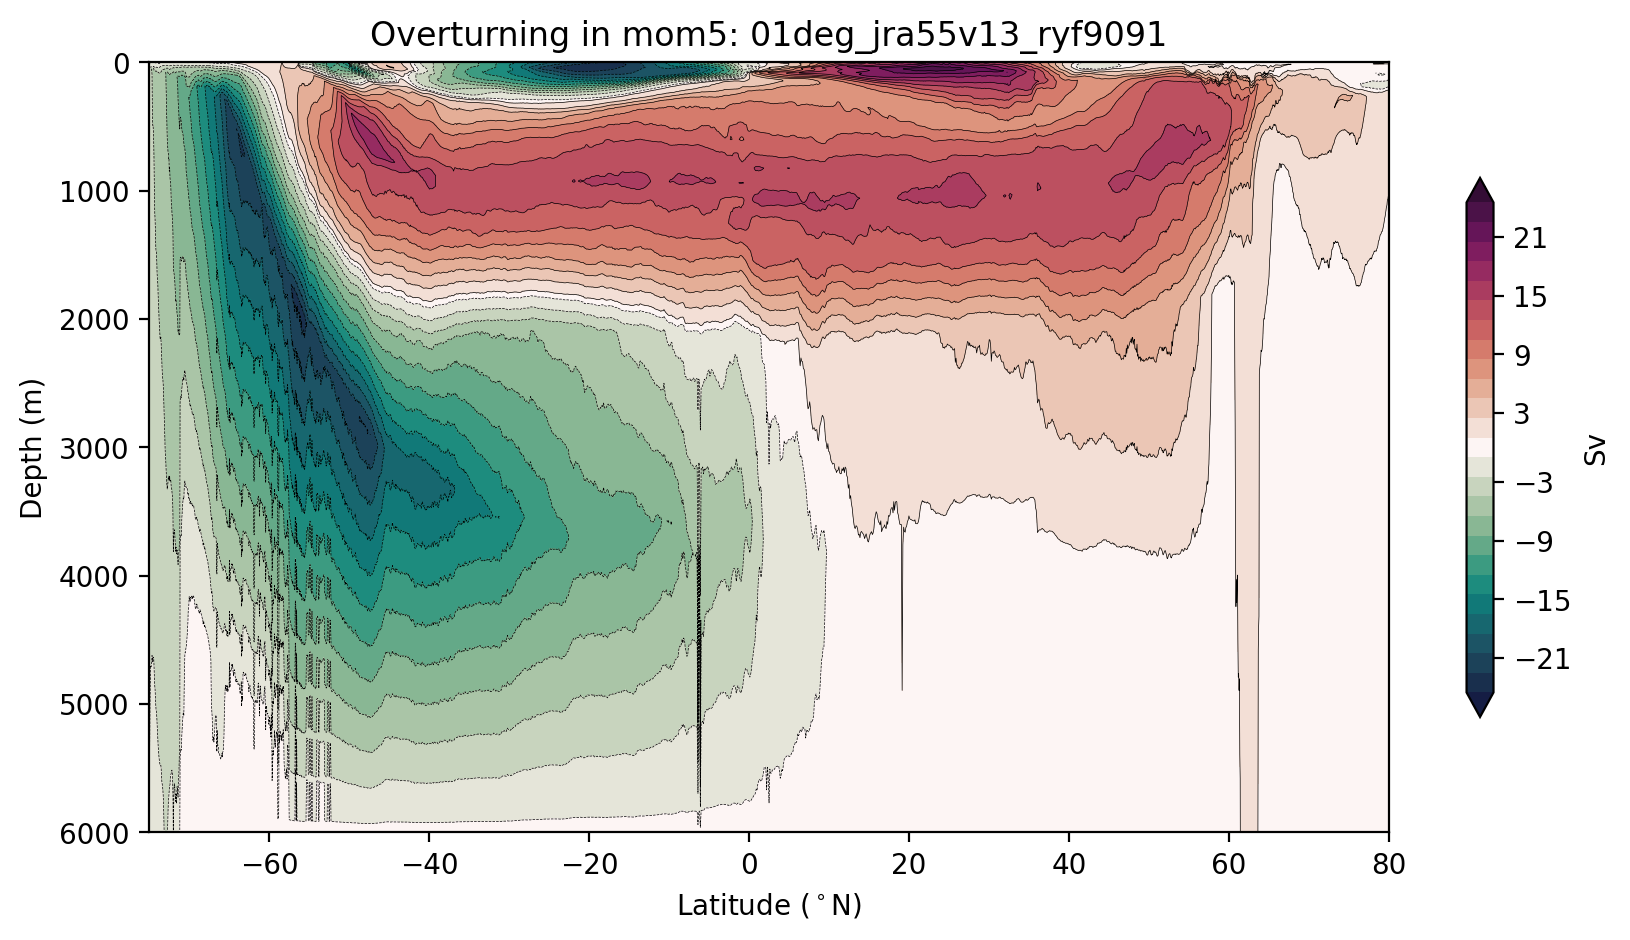

In [13]:
plt.figure(figsize=(10, 5))

max_psi = 24.5 # Sv

# how we compute the levels may seem complicated, we just want to avoid a 0 contour
# so that the plot looks soothing to the eye
levels =  np.hstack((np.arange(-max_psi, 0, 2), np.flip(-np.arange(-max_psi, 0, 2))))
cbarticks = np.hstack((np.flip(-np.arange(3, max_psi, 6)), np.arange(3, max_psi, 6)))

new_psi_avg.plot.contourf(y="depth",levels=levels,
                      cmap=cm.cm.curl, extend='both',
                      cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})
new_psi_avg.plot.contour(y="depth",levels=levels, colors='k', linewidths=0.25)

plt.gca().invert_yaxis()


plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 80])
plt.title(f'Overturning in {model}: {psi_args[model]["expt"]}');

Now let's do it again from a MOM6 model. Easy!

In [14]:
model = 'mom6'
psi, psiGM, GM = load_streamfunction(model)
psi_avg = sum_in_vertical(psi, psiGM, GM)

2023-09-04 15:41:43,613 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-09-04 15:41:43,617 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-09-04 15:41:48,961 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-09-04 15:41:50,554 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-09-04 15:41:51,058 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-09-04 15:41:52,025 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-09-04 15:41:53,657 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-09-04 15:41:55,282 - distributed.utils_perf - WARNING - full garbage collections took

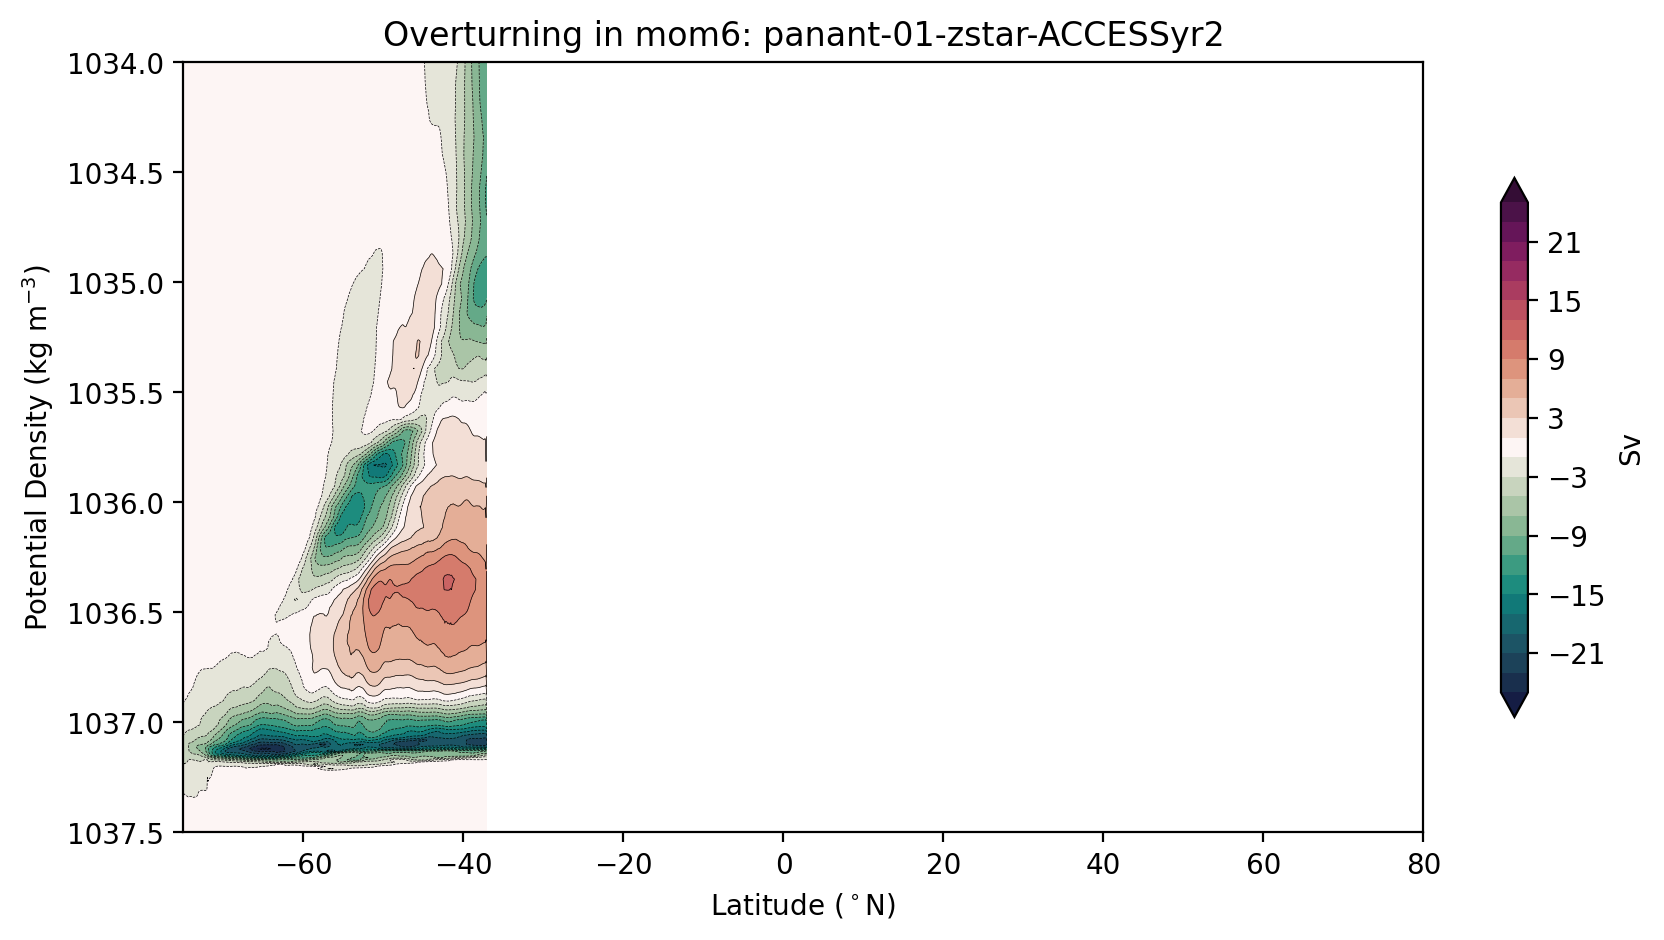

In [15]:
plt.figure(figsize=(10, 5)) 

max_psi = 25 # Sv

# how we compute the levels may seem complicated, we just want to avoid a 0 contour
# so that the plot looks soothing to the eye
levels =  np.hstack((np.arange(-max_psi, 0, 2), np.flip(-np.arange(-max_psi, 0, 2))))
cbarticks = np.hstack((np.flip(-np.arange(3, max_psi, 6)), np.arange(3, max_psi, 6)))

psi_avg.plot.contourf(levels=levels,
                      cmap=cm.cm.curl, extend='both',
                      cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})

psi_avg.plot.contour(levels=levels, colors='k', linewidths=0.25)

plt.gca().invert_yaxis()

plt.ylim((1037.5, 1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 80])
plt.title(f'Overturning in {model}: {psi_args[model]["expt"]}');

Alternatively, you may want to stretch your axes to minimise the visual impact of the surface circulation, while showing the full-depth ocean.

In [16]:
stretching_factor = 4 # A powvalues set the stretching

ρmin = psi_avg.cf['vertical'].min()

psi_avg_plot = psi_avg.assign_coords(
    {
        psi_avg.cf["vertical"].name: (psi_avg.cf["vertical"] - ρmin)**stretching_factor
    }
)

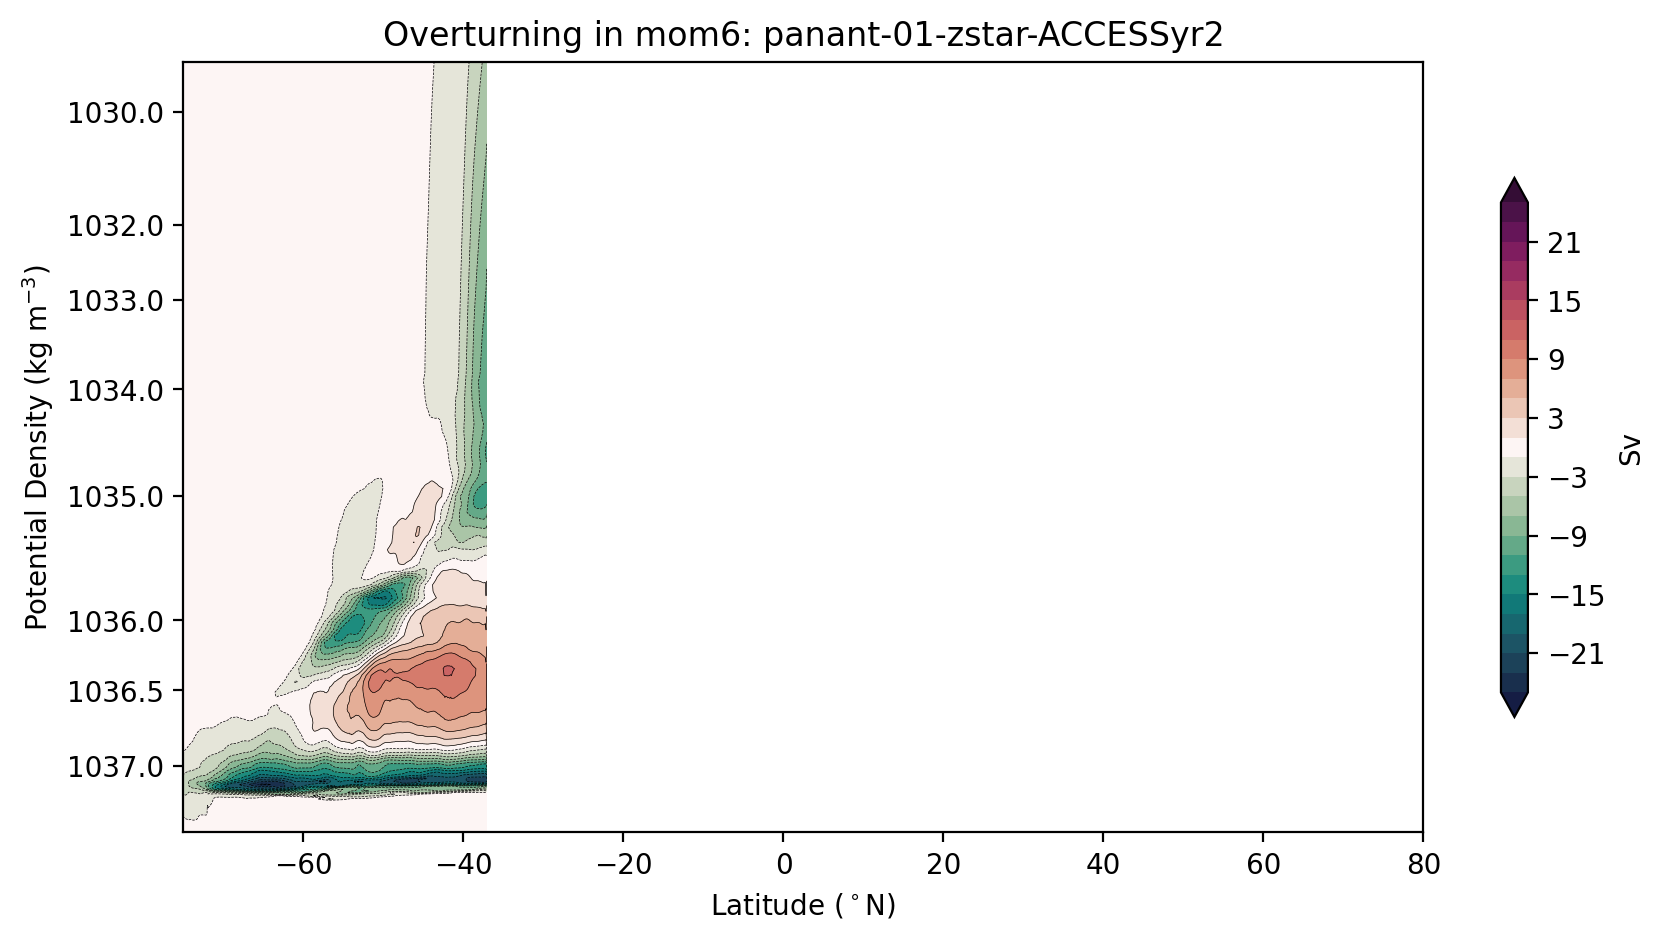

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

max_psi = 25 # Sv

# how we compute the levels may seem complicated, we just want to avoid a 0 contour
# so that the plot looks soothing to the eye
levels =  np.hstack((np.arange(-max_psi, 0, 2), np.flip(-np.arange(-max_psi, 0, 2))))
cbarticks = np.hstack((np.flip(-np.arange(3, max_psi, 6)), np.arange(3, max_psi, 6)))

yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036, 1036.5, 1037])

psi_avg_plot.plot.contourf(levels=levels, 
                           cmap=cm.cm.curl, extend='both',
                           cbar_kwargs={'shrink': 0.7,'label': 'Sv', 'ticks': cbarticks})

psi_avg_plot.plot.contour(levels=levels, colors='k', linewidths=0.25)

plt.gca().set_yticks((yticks - ρmin.values)**stretching_factor)
plt.gca().set_yticklabels(yticks)

# ylims: a bit less than the minimnum and a bit more than the maximum values
plt.gca().set_ylim([((yticks - ρmin.values).min() / 1.1)**stretching_factor, ((yticks - ρmin.values).max() * 1.02)**stretching_factor])
plt.gca().invert_yaxis()

plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 80])
plt.title(f'Overturning in {model}: {psi_args[model]["expt"]}');

Remapping mom6 into depth coordinates

In [18]:
psi_depth, new_psi_avg = remap_depth(remap_dens,psi_args,psi_avg,session,model)

2023-09-04 15:42:27,286 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-09-04 15:42:27,909 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-09-04 15:42:30,065 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-09-04 15:42:30,113 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-09-04 15:42:34,883 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-09-04 15:42:35,360 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-09-04 15:42:35,803 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-09-04 15:42:36,436 - distributed.utils_perf - WARNING - full garbage collections took

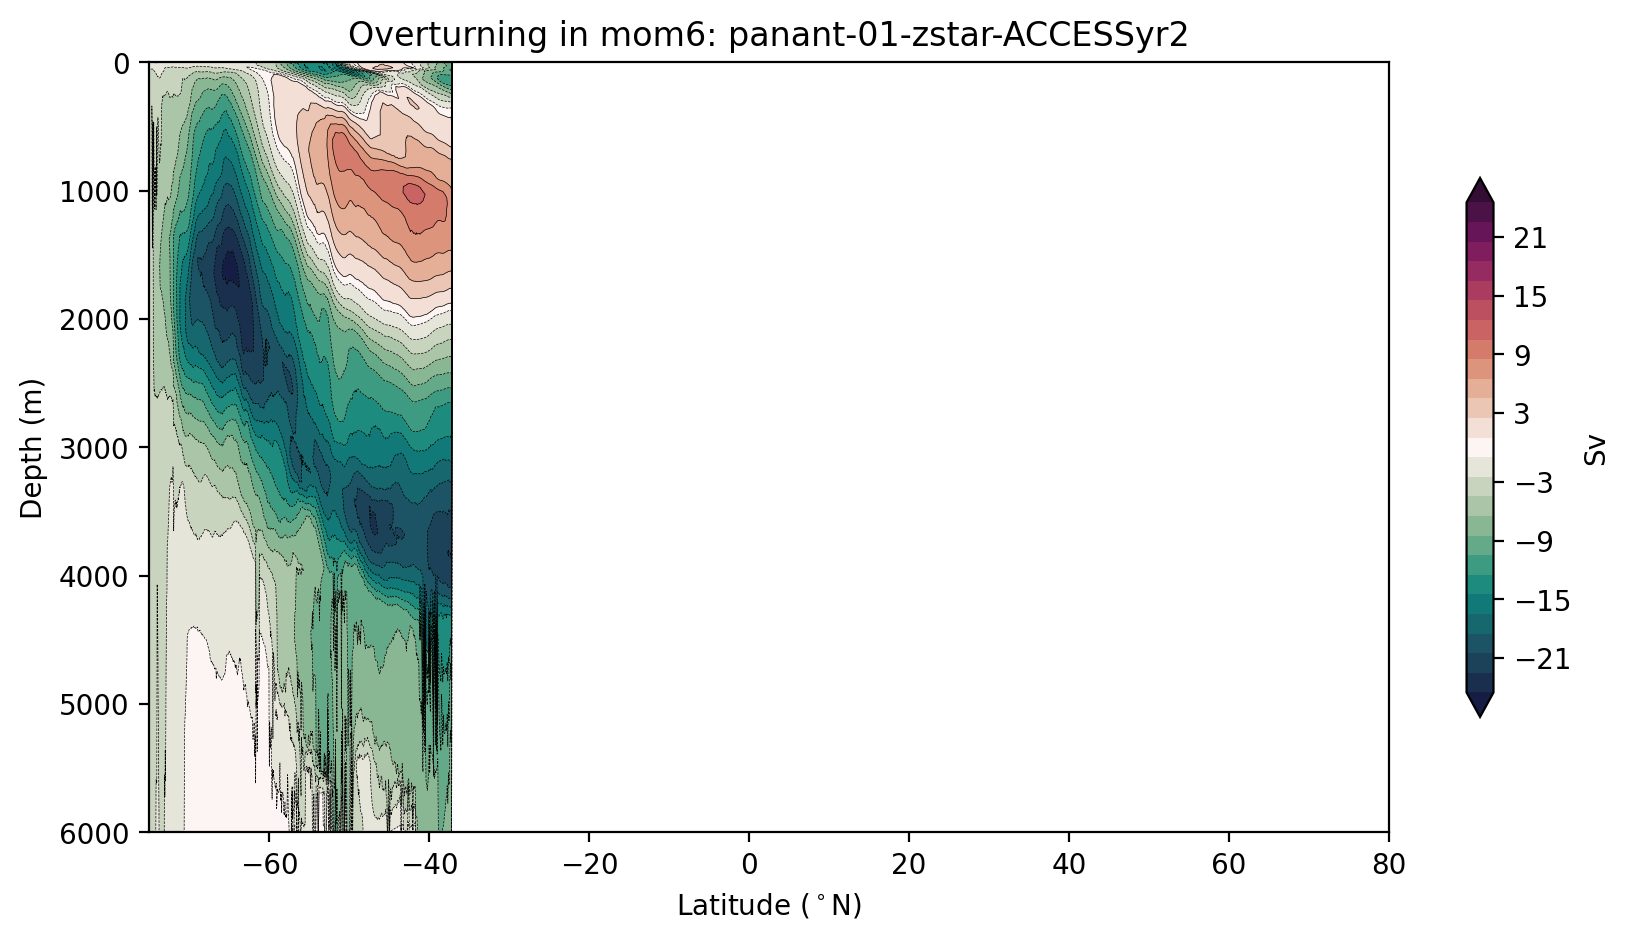

In [19]:
plt.figure(figsize=(10, 5))

max_psi = 24.5 # Sv

# how we compute the levels may seem complicated, we just want to avoid a 0 contour
# so that the plot looks soothing to the eye
levels =  np.hstack((np.arange(-max_psi, 0, 2), np.flip(-np.arange(-max_psi, 0, 2))))
cbarticks = np.hstack((np.flip(-np.arange(3, max_psi, 6)), np.arange(3, max_psi, 6)))

new_psi_avg.plot.contourf(y="depth",levels=levels,
                      cmap=cm.cm.curl, extend='both',
                      cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})
new_psi_avg.plot.contour(y="depth",levels=levels, colors='k', linewidths=0.25)

plt.gca().invert_yaxis()


plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 80])
plt.title(f'Overturning in {model}: {psi_args[model]["expt"]}');

**Notes:**

 * We have not included the submesoscale contribution to the meridional transport in these calculations, as it tends to be relatively unimportant for the deep circulation, which we where we are primarily interested.

 * These metrics do not use mathematically correct zonal averaging in the tripole region, north of 65°N!